# Sampling
In order to develop the most robust system possible, we would like to create subsets of data for our solution. This will give us the chance to develop, finetune and test our model. In short, we'll be creating three sets:

1. a training set to train our model
2. a validation set to choose between models
3. a test set tells to give us a better estimate as to how well the solution performs in the real world

## The right ratio
While in former machine learning times leading practitioners and researchers suggested splits like 70% training 30 % testing or 60 % training, 20 % development/validation, 20 % testing, this might not hold true for every setup. Especially in cases with more data, different ratios might be more appropriate. 

The trend for development and test set ratios is to go decrease with larger data sets. The most important reason for this is the purpose of development and test sets. The goal of the development set is to test different algorithms and measure their performance. Therefore the dev-set just needs to be big enough to evaluate the different algorithm choices. To evaluate this quickly and iteratively, it doesn't need 20 % of the overall data. The same holds true for the test set. For its purpose, to get an estimate of how good the algorithm would perform on a real life set the test data doesn't need 200,000 data points when the base is 1,000,000. 

In this research which uses a data set with 1,000,000 observations containing 66,000,000 song mentions, we'll be taking a more fitting approach slicing the data into the following ratios:

| Data        |  Data Points  | Ratio |
|-------------|--------------:|------:|
| total       |   1,000,000   |  100% |
| training    |     980,000   |   98% |
| development |      10,000   |    1% |
| testing     |      10,000   |    1% |

Those ratios also reflect the challenge data set which will be used by the RecSys organizers to evaluate their official challenge. 

## Stratification
To slice the right samples we're looking for three data sets that share their main characteristics. To determine which features might be exceptionally important and to keep all options available, but not overcomplicate the sampling process we'll be focusing on the following dimensions:

* **Item Size:** num_tracks
* **Popularity:** track_popularity_median
* **Time:** modified_at

These are the features we'll be adjusting for. The reasoning behind it is

1. We'd like to capture a similar amount of information and a similar set of lengths per playlist within each sample
2. We'd love to keep the effect of popular items in mind when choosing our subsample
3. Time and zeitgeist are huge factors when it comes to music. In this case we want to maximize the chances to have the most recent tracks mentioned in all of our used sets.

In [1]:
import datetime
import json
import numpy as np
import os
import pandas as pd
import pickle
import scipy
import seaborn as sns
import time

from collections import Counter
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

random_state = 2018
np.random.seed(random_state)


recompute = False

RESULTS_FOLDER = 'results/sampling/'

In [2]:
def load_pickle_obj(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)

In [3]:
playlist_df = pd.read_csv('results/playlist_df.csv', index_col=0)

In [4]:
playlist_df.head()

,name,collaborative,pid,modified_at,num_albums,num_followers,num_edits,duration_ms,num_artists,artist_popularity,artist_popularity_mean,artist_popularity_median,track_popularity,track_popularity_mean,track_popularity_median,description,num_tracks
0,Jazz,False,521000,1453593600,38,1,7,9905926,27,833854,20846.350000,14285.0,136491,3412.275000,1620.5,NaN,40
1,Noosa Tastiest Playlist,False,521001,1474502400,30,1,2,7784873,30,520253,17341.766667,3611.5,28213,940.433333,262.5,NaN,30
2,Worship,False,521002,1473638400,6,1,2,2113613,6,199232,33205.333333,24804.5,4404,734.000000,751.5,NaN,6
3,CANCUN,False,521003,1404777600,12,1,4,3316480,12,1070261,82327.769231,88500.0,45489,3499.153846,1437.0,NaN,13
4,Dancing,False,521004,1382313600,18,1,14,4540444,17,677011,37611.722222,6159.5,29732,1651.777778,193.5,NaN,18


## Preprocessing
Before we can stratify we need to create population classes regarding those features. Since stratification works best on categorical variables and classes within features we need to transforn continuous representations into discrete representations. In those classes we want to capture the general trend of any given feature. 

### Binning Aproaches
In general we're investigating two binning approaches for this task: Equal-width binning and quantile binning. Equal-width splits up the range of a column according to its minimum and maximum values in equal sized bin boundaries. Afterwards it uses those boundaries to assign each of the observations to a bin. When splitting on quantiles, we're trying to assign an equal amount of observations to each bin.

### Bin Size
Because we're splitting into three sets in total and are dealing with a few popular but infrequent observations the bin size shouldn't be too large. If chosen too large we will most likely end up with a scenario where there are not enough observations for a given class to be represented in all three datasets (minimum 3 occurances if split on 3 data sets).

There are a few ways on how to determine bin sizes from [Freedman-Diaconis rule](https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule) which takes into account the Inner Quartile Range to [Doane's formula](https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width) or simply taking the square root of the number of observations.

### Freedman–Diaconis rule
$$ b = 2  \frac{IQR(x)}{\sqrt[3] n} $$

In [5]:
def get_iqr(df, feature):
    return df[feature].quantile(.75) - df[feature].quantile(.25)

In [6]:
get_iqr(playlist_df, 'track_popularity_median')

4195.5

In [7]:
def freedman_diaconis_rule(df, feature):
    iqr = get_iqr(df, feature)
    n = len(df)
    return int(np.ceil(2 * iqr / np.cbrt(n)))

In [8]:
feature_list = ['num_tracks', 'modified_at', 'track_popularity_median']

In [9]:
for feature in feature_list:
    print ('{}: {:,} bins'.format(feature, freedman_diaconis_rule(playlist_df, feature)))

num_tracks: 2 bins
modified_at: 929,664 bins
track_popularity_median: 84 bins


#### Problem: Non-normal distribution
One problem arises for our data distributions using the Freedman-Diaco rule. The formula relies strongly on the inner-quartile range to model any skewness of the distribution. While 84 bins for `track_popularity_median` might be a reasonable amount for plotting it might be too restrictive for random sampling and the aforementioned constraints to contain at least 3 observations in each class. When looking at `num_tracks` and `modified_at` the shortcomings of Freedman-Diaco rule when operating on non-normal distributions become obvious. The skewness of the data leads to too small or too large bin sizes.

### Doane's formula
Doane's formula tries to take skewness into account. This might be a better fit for our distributions since we're not sampling from gaussian distributions but in fact are dealing with density functions that are skewed towards right or left.

$$ k = 1 + \log_2( n ) + \log_2 \left( 1 +  \frac { |g_1| }{\sigma_{g_1}} \right) $$
where $g_{1}$ is the skewness of the distribution, $n$ the amount of observations and $\sigma_{g_1}$ calculated as:

$$ \sigma_{g_1} = \sqrt { \frac { 6(n-2) }{ (n+1)(n+3) } }  $$

In [10]:
def doanes_formula(df, feature, verbose=False):
    n = len(df)
    g1 = scipy.stats.skew(df[feature])
    sigma_g1 = np.sqrt((6 * (n - 2)) / (n + 1) * (n + 3))
    if verbose:
        print ('g1: {} (np.log2: {:.4f})\nsigma_g1: {}'.format(g1, np.log2(np.abs(g1)), sigma_g1))
    
    return int(np.ceil(1 + np.log2(n) + np.log2(1 + (np.abs(g1) / sigma_g1))))

In [11]:
for feature in feature_list:
    print ('{}: {:,} bins'.format(feature, doanes_formula(playlist_df, feature)))

num_tracks: 21 bins
modified_at: 21 bins
track_popularity_median: 21 bins


This is giving a more consistant and reasonable result. The amount of classes is influenced by the skewness of the data leading to a negative penalty if the last term of the function becomes small (due to taking its $log_{2}$). Since all features have the same amount of observations and a similar amount of skewness, the bin size is equally large. 

Histogram for feature 'num_tracks'


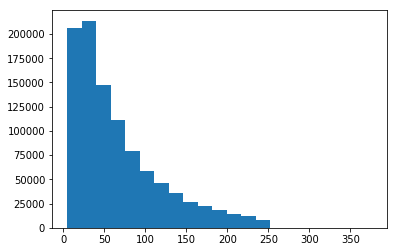

In [12]:
print ('Histogram for feature \'{}\''.format(feature_list[0]))
count = plt.hist(playlist_df[feature_list[0]], bins=21)

#### Problem: Outliers
There is only one problem that needs fixing. With this bin size, we can still end up in cases where there are outliers that have their separate class or there are classes that have no members. In the specific case of `num_tracks` the class distributions are looking like this:

In [13]:
count[1]

array([  5.        ,  22.66666667,  40.33333333,  58.        ,
        75.66666667,  93.33333333, 111.        , 128.66666667,
       146.33333333, 164.        , 181.66666667, 199.33333333,
       217.        , 234.66666667, 252.33333333, 270.        ,
       287.66666667, 305.33333333, 323.        , 340.66666667,
       358.33333333, 376.        ])

In [14]:
print ('{:>10}{:>30}{:>20}'.format('Class', 'Members', 'Boundary'))
print ('='*60)
for c, b in enumerate(zip(count[0], count[1])):
    print ('{:>10}{:>30,}{:>20}'.format(c, b[0], round(b[1],2)))

     Class                       Members            Boundary
         0                     206,222.0                 5.0
         1                     213,715.0               22.67
         2                     147,069.0               40.33
         3                     110,968.0                58.0
         4                      79,528.0               75.67
         5                      58,313.0               93.33
         6                      46,248.0               111.0
         7                      35,529.0              128.67
         8                      26,740.0              146.33
         9                      22,852.0               164.0
        10                      17,921.0              181.67
        11                      14,489.0              199.33
        12                      12,267.0               217.0
        13                       8,138.0              234.67
        14                           0.0              252.33
        15              

Classes 14 to 19 have no members and class 20 has only one member. This will make it impossible to stratify on these distributions. A simple fix is, to exclude any class that has less than the minimum amount of members needed (3 in our case) from binning and include its members in the last accepted class. We can simply arrange for this by adjusting the boundaries. 

In [15]:
def adjust_bins(df, feature, bins, sets=3):
    histogram_tuple = np.histogram(playlist_df[feature], bins)
    return_boundaries = histogram_tuple[1]
    del_count = 0
    del_list = []
    for idx, c in enumerate(histogram_tuple[0]):
        if c < sets:
            del_list.append(idx)
    return_boundaries = np.delete(return_boundaries, del_list)
    if del_list:
        print ('Reduced bin size to {}.'.format(bins - len(del_list)))
    return return_boundaries

In [16]:
print (feature_list[0])
num_track_bins = adjust_bins(playlist_df, feature_list[0], 21)

num_tracks
Reduced bin size to 14.


In [17]:
num_track_bins

array([  5.        ,  22.66666667,  40.33333333,  58.        ,
        75.66666667,  93.33333333, 111.        , 128.66666667,
       146.33333333, 164.        , 181.66666667, 199.33333333,
       217.        , 234.66666667, 376.        ])

In [18]:
def get_feature_class_bin(row, bin_boundaries):
    """
    Helper method for stratification. 
    Returns class label based on bin boundaries.
    
    Parameters:
    --------------
    row:             int, data point or series entry
    bin_boundaries:  list with bin boundaries [0]: min value [-1]: max value
    
    Returns:
    --------------
    class:           int, range(0,len(bin_boundaries)) - determining class
    """
    if row < bin_boundaries[1]:
        return 0
    for q in range(len(bin_boundaries) - 1):
        if row >= bin_boundaries[q] and row < bin_boundaries[q+1]:
            return q
    return len(bin_boundaries)-1

#### Quick test of boundaries function

In [19]:
def assertEquals(var1, var2):
    if var1 == var2:
        return True
    else:
        return False

In [20]:
bin_boundaries = [1, 10, 100, 200]

In [21]:
rows = [1, 9, 11, 10, 90, 101, 199, 200, 204]
assertions = [0, 0, 1, 1, 1, 2, 2, 3, 3]

In [22]:
for idx, row in enumerate(rows):
    if not (assertEquals(get_feature_class_bin(row, bin_boundaries), assertions[idx])):
        print ('Error with value {} (Expected {} got {})'.format(
            row, assertions[idx], get_feature_class_bin(row, bin_boundaries)))

In [23]:
playlist_df_test = playlist_df.copy()

### Preprocessing `num_tracks`

In [24]:
nt_bins = doanes_formula(playlist_df, 'num_tracks')

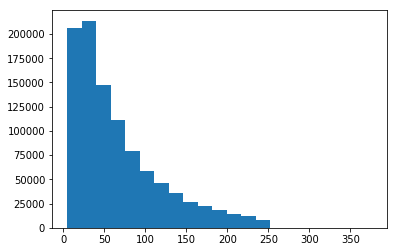

In [25]:
bins = plt.hist(playlist_df['num_tracks'], bins=nt_bins)

In [26]:
nt_bin_list = adjust_bins(playlist_df, 'num_tracks', nt_bins)

Reduced bin size to 14.


In [27]:
playlist_df['num_tracks_class'] = playlist_df['num_tracks'].apply(get_feature_class_bin, args=(nt_bin_list, ))

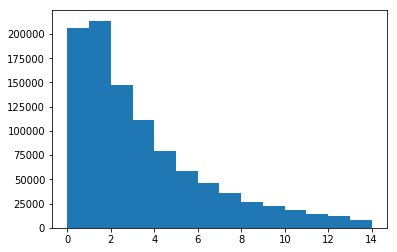

In [28]:
_ = plt.hist(playlist_df['num_tracks_class'], bins=14)

### Preprocessing `modified_at`

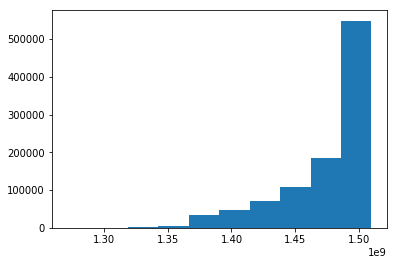

In [29]:
_ = plt.hist(playlist_df['modified_at'], bins=10)

In [30]:
ma_bins = doanes_formula(playlist_df, 'modified_at')

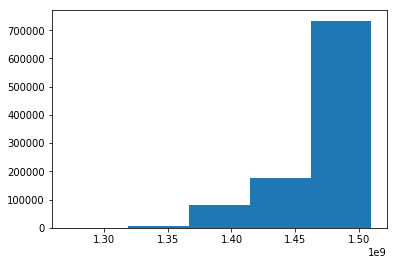

In [31]:
bins = plt.hist(playlist_df['modified_at'], bins=5)

In [32]:
ma_bin_list = adjust_bins(playlist_df, 'modified_at', ma_bins)

In [33]:
playlist_df['modified_at_class'] = playlist_df['modified_at'].apply(get_feature_class_bin, args=(ma_bin_list, ))

### Preprocessing `track_popularity_median`

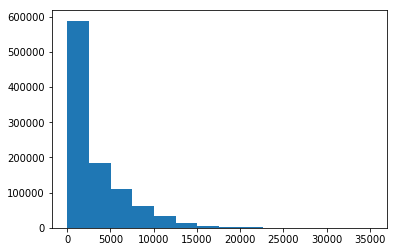

In [34]:
_ = plt.hist(playlist_df['track_popularity_median'], bins=14)

In [35]:
pop_bins = doanes_formula(playlist_df, 'track_popularity_median')

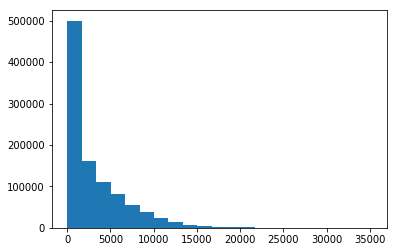

In [36]:
bins = plt.hist(playlist_df['track_popularity_median'], bins=pop_bins)

In [37]:
pop_bin_list = adjust_bins(playlist_df, 'track_popularity_median', pop_bins)

In [38]:
playlist_df['track_popularity_median_class'] = playlist_df['track_popularity_median'].apply(
    get_feature_class_bin, args=(pop_bin_list, ))

## Quantiles
Another option to slice the data set into samples with similar characteristics that works well for skewed distributions is using quantiles. This approach comes with its own drawbacks but it handles outliers intuitively and contains more randomness in each bin. 

The biggest problem with this approach yet is asking for more bins than reasonable. This might happen when dealing with long-tails where multiple quantile steps describe the same boundary.

In [39]:
def get_feature_class(row, quantile_list):
    """
    Helper method for stratification. 
    Returns class label based on quantile boundaries.
    
    Parameters:
    --------------
    row:            int, data point or series entry
    quantile_list:  list with quantile measures
    
    Returns:
    --------------
    class:          int, range(0,len(quantile_list)) - determining class
    """
    if row <= quantile_list[0]:
        return 0
    for q in range(len(quantile_list) - 1):
        if row > quantile_list[q] and row <= quantile_list[q+1]:
            return q+1

In [40]:
def qs(q):
    """
    Helper method for quantile list. 
    Calculates quantile steps for q number of quantiles.
    
    Parameters:
    --------------
    q:    int, number of quantiles
    
    Returns:
    --------------
    quantile_list:    list of quantile steps
    """
    step = 100 / q
    quantile_list = []
    
    for i in range(1,q+1):
        quantile_list.append(i * step / 100)
    return quantile_list

In [41]:
def get_quantile_list(df, feature, bins=10):
    """
    Returns q quantile boundaries for a feature in a dataset. 
    
    Parameters:
    --------------
    df:      pandas.DataFrame
    feature: str, column name of feature
    bins   : amount of bins
    
    Returns:
    --------------
    quantile_list: list of boundaries to get quantile distribution
    """
    error_msg = None
    # create quantile pointers
    quantile_steps = qs(bins)
    quantile_list = []
    for step in quantile_steps:
        quant = df[feature].quantile(step)
        if quant not in quantile_list:
            quantile_list.append(quant)
        else:
            error_msg = 'Warning: Reduced bin size to'
    if error_msg:
        error_msg += ' {} bins.'.format(len(quantile_list))
        print (error_msg)
    return quantile_list

In [42]:
num_edits_ql = get_quantile_list(playlist_df, 'num_edits', bins=100)

In [43]:
test_bins = doanes_formula(playlist_df, 'num_edits')

### nt_quantile

In [44]:
nt_quantile_list = get_quantile_list(playlist_df, 'num_tracks', bins=14)

In [45]:
playlist_df['num_tracks_class_quantile'] = playlist_df['num_tracks'].apply(get_feature_class, args=(nt_quantile_list, ))

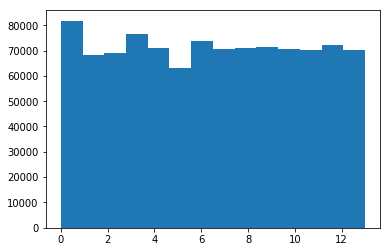

In [46]:
_ = plt.hist(playlist_df['num_tracks_class_quantile'], bins=14)

### ma_quantile

In [47]:
ma_quantile_list = get_quantile_list(playlist_df, 'modified_at', bins=21)

In [48]:
playlist_df['modified_at_class_quantile'] = playlist_df['modified_at'].apply(get_feature_class, args=(ma_quantile_list, ))

### pop_quantile

In [49]:
pop_quantile_list = get_quantile_list(playlist_df, 'track_popularity_median', bins=21)

In [50]:
playlist_df['track_popularity_median_class_quantile'] = playlist_df['track_popularity_median'].apply(
    get_feature_class, args=(pop_quantile_list, ))

## Complexity
Since our goal is, to stratify given a combination of three features the amount of classes can have a huge impact. While we're dealing with a strongly skewed dataset the chances that infrequent combinations pop up is very high. The lower the amount of classes we need per feature, the better are our chances to end up with no infrequent combinations. There are ways of dealing with those rare occacions (i.e. finding nearest non-rare neighbor of rare solution) or we could discard some of the outlier data points. Since we would like to include as much information as possible and don't want to make the sampling process more complex than needed we're opting to choose a smaller amount of classes per feature if needed.

## Stratification-Analysis
To determine the best working bin size and method, we'll be using a similar evaluation method than sklearn's StratifiedShuffleSplit. We'll be looking at all possible class combinations of the selected features and determine how many combinations appear less than 3 times (because we need to split for 3 different sets).

In [51]:
def stratify_test(df, sets=3):
    y_strat = np.array([' '.join(row.astype('str')) for row in df.values])
    print ('Combination example: {}'.format(y_strat[0]))
    y_strat_count = Counter(y_strat).most_common()
    unstrats = [x for x in y_strat_count if x[1] < sets]
    unstrats_count = np.sum([x[1] for x in unstrats]) 
    print ('{:,} unique feature combination(s) with less than {} observations. (Total: {} datapoints)'.format(
        len(unstrats), sets, unstrats_count))

    unstrats_set = [x[0] for x in unstrats]
    
    unstrats_ids = []
    for idx, strat_el in enumerate(y_strat):
        if strat_el in unstrats_set:
            unstrats_ids.append(idx)
    return unstrats_ids

In [52]:
unstrat_ids = stratify_test(
    playlist_df[['track_popularity_median_class', 'num_tracks_class', 'modified_at_class']], sets=3)

Combination example: 0 1 16
227 unique feature combination(s) with less than 3 observations. (Total: 304 datapoints)


In [53]:
unstrat_ids_quantile = stratify_test(
    playlist_df[['track_popularity_median_class_quantile', 
                 'num_tracks_class_quantile', 
                 'modified_at_class_quantile']], sets=3)

Combination example: 10 5 4
13 unique feature combination(s) with less than 3 observations. (Total: 17 datapoints)


In [54]:
playlist_df[playlist_df.index.isin(unstrat_ids_quantile)][[
    'track_popularity_median_class_quantile', 'num_tracks_class_quantile', 'modified_at_class_quantile']].head()

,track_popularity_median_class_quantile,num_tracks_class_quantile,modified_at_class_quantile
18698,20,4,0
114001,20,13,6
181197,20,11,2
183131,20,4,0
183344,20,5,0


### Adjustments: Bins

In [55]:
nt_bin_list = adjust_bins(playlist_df, 'num_tracks', 3)

Reduced bin size to 2.


In [56]:
playlist_df['num_tracks_class'] = playlist_df['num_tracks'].apply(get_feature_class_bin, args=(nt_bin_list, ))

In [57]:
ma_bin_list = adjust_bins(playlist_df, 'modified_at', 3)

In [58]:
playlist_df['modified_at_class'] = playlist_df['modified_at'].apply(get_feature_class_bin, args=(ma_bin_list, ))

In [59]:
pop_bin_list = adjust_bins(playlist_df, 'track_popularity_median', 3)

In [60]:
playlist_df['track_popularity_median_class'] = playlist_df['track_popularity_median'].apply(
    get_feature_class_bin, args=(pop_bin_list, ))

In [63]:
unstrat_ids = stratify_test(
    playlist_df[['track_popularity_median_class', 'num_tracks_class', 'modified_at_class']], sets=3)

Combination example: 0 0 2
2 unique feature combination(s) with less than 3 observations. (Total: 2 datapoints)


In [62]:
playlist_df[playlist_df.index.isin(unstrat_ids)][[
    'track_popularity_median_class', 'num_tracks_class', 'modified_at_class']].head()

,track_popularity_median_class,num_tracks_class,modified_at_class
5786,1,1,2
7528,1,0,2
12551,2,0,2
13153,1,0,3
17283,0,1,1


Even with as low as three bin groups per feature it is not possible to mitigate infrequent combinations.

### Adjustments: Quantiles
After lowering the precentile steps to 10 per quantile calculation, none of the categories is part of a combination that appears less than three times.

In [64]:
nt_quantile_list = get_quantile_list(playlist_df, 'num_tracks', bins=10)
ma_quantile_list = get_quantile_list(playlist_df, 'modified_at', bins=10)
pop_quantile_list = get_quantile_list(playlist_df, 'track_popularity_median', bins=10)

In [65]:
playlist_df['num_tracks_class_quantile'] = playlist_df['num_tracks'].apply(get_feature_class, args=(nt_quantile_list, ))
playlist_df['modified_at_class_quantile'] = playlist_df['modified_at'].apply(get_feature_class, args=(ma_quantile_list, ))
playlist_df['track_popularity_median_class_quantile'] = playlist_df['track_popularity_median'].apply(
    get_feature_class, args=(pop_quantile_list, ))

In [66]:
unstrat_ids_quantile = stratify_test(
    playlist_df[['track_popularity_median_class_quantile', 
                 'num_tracks_class_quantile', 
                 'modified_at_class_quantile']], sets=3)

Combination example: 4 4 2
0 unique feature combination(s) with less than 3 observations. (Total: 0.0 datapoints)


A heavy skew on all three features makes it hard to find bin combinations that work for a multi-stratifying approach. One option would be to exclude the outliers but since we accept a skewed data set and expect future outliers according to this data set in the unseen test cases we want to include those as well. Another option would be to use post-stratification or raking after stratifying on one feature and weighing the other features accordingly. Since we have a quantile solution that is quite robust against skew and a decent amount of classes which seem to be able to explain trends within the data. We'll cross-check this later on.

## Load all Tracks

In [67]:
def save_pickle_obj(obj, fname):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f)
        print ('File stored under {}'.format(fname))

In [68]:
mpd_data_fname = '../../workspace/data/'

In [ ]:
all_playlists_fname = 'all_playlists.pckl'
if recompute:
    all_playlists = {}
    file_names = os.listdir(mpd_data_fname)
    file_names = [x for x in file_names if '.json' in x]
    counter = 0
    total_files = len(file_names)
    for file_name in file_names:
        counter += 1
        clear_output(wait=True) 
        print ("Working on slice {} ({:.2f} %) (File Name:  {} || Total Slices: {})".format(
                counter, (counter / total_files) * 100, file_name, total_files))
        with open(os.path.join(mpd_data_fname, file_name), 'r') as f:
            json_tmp = json.load(f)
            for playlist in json_tmp['playlists']:
                all_playlists[playlist['pid']] = [x['track_uri'] for x in playlist['tracks']]
    all_playlists_fname = 'all_playlists.pckl'
    save_pickle_obj(all_playlists, os.path.join('../../workspace/', all_playlists_fname))
else:
    all_playlists = load_pickle_obj(os.path.join('../../workspace/', all_playlists_fname))

In [ ]:
len(all_playlists)

## Split
After creating the classes to stratify on, sklearn's `train_test_split` method is being leveraged to determine the playlists. To meet the second criteria for all tracks in the dev and test sets to be in the training set a bigger split is being produced. Afterwards all candidates are being investigated for rare tracks. If a playlist contains a track that's not in the training set, the playlist is being removed from the candidate list. From the remaining candidates a random sample of two times 10,000 is being drawn to determine the dev and test sets.

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
X_train_full, X_test = train_test_split(
    playlist_df, test_size=.1, random_state=random_state, stratify=playlist_df[
        ['track_popularity_median_class_quantile', 'num_tracks_class_quantile', 'modified_at_class_quantile']])

In [72]:
X_train_full = X_train_full.copy()

In [73]:
# get all tracks from X_train_full set

In [74]:
x_train_pids = X_train_full.pid.values

In [75]:
x_test_pids = X_test.pid.values

In [76]:
import sys
sys.path.append('../src/')

In [77]:
import os

In [78]:
all_tracks = set()
test_playlists = {}
file_names = os.listdir(mpd_data_fname)
file_names = [x for x in file_names if '.json' in x]
total_files = len(all_playlists)
for p in all_playlists:
    if p in x_train_pids:
        for track in all_playlists[p]:
            all_tracks.add(track)
    elif p in x_test_pids:
        test_playlists[p] = all_playlists[p]

In [ ]:
# check if all tracks in test set are in X_train_full

In [79]:
missing_pid = {}
candidates = []
for t in test_playlists:
    is_candidate = True
    for track in test_playlists[t]:
        if track not in all_tracks:
            is_candidate = False
            if t not in missing_pid:
                missing_pid[t] = 1
            else:
                missing_pid[t] += 1
    if is_candidate:
        candidates.append(t)

In [80]:
print ('There are {:,} playlists that contain songs that are not in the training set.'.format(len(missing_pid)))

There are 23,302 playlists that contain songs that are not in the training set.


In [81]:
dev_test = np.random.choice(candidates, 20000, replace=False)
dev_test = shuffle(dev_test, random_state=random_state)
dev, test = dev_test[:10000], dev_test[10000:]

In [82]:
len(dev), len(test)

(10000, 10000)

In [83]:
X_dev = playlist_df[playlist_df.pid.isin(dev)].copy()

In [84]:
len(X_test)

100000

In [85]:
X_test = playlist_df[playlist_df.pid.isin(test)].copy()

In [86]:
X_train = playlist_df[~playlist_df.pid.isin(test) & ~playlist_df.pid.isin(dev)].copy()

In [87]:
len(X_train)

980000

## Distribution Plots
To investigate whether the method worked well for our dataset, we'll perform the same method to sample a development set. 

In [243]:
nt_quantile_list = get_quantile_list(X_train, 'num_tracks', bins=10)
ma_quantile_list = get_quantile_list(X_train, 'modified_at', bins=10)
pop_quantile_list = get_quantile_list(X_train, 'track_popularity_median', bins=10)

In [244]:
X_train.drop(
    ['num_tracks_class_quantile', 'modified_at_class_quantile', 'track_popularity_median_class_quantile'],
    axis=1,
    inplace=True)

In [245]:
X_train['num_tracks_class_quantile'] = X_train['num_tracks'].apply(get_feature_class, args=(nt_quantile_list, ))
X_train['modified_at_class_quantile'] = X_train['modified_at'].apply(get_feature_class, args=(ma_quantile_list, ))
X_train['track_popularity_median_class_quantile'] = X_train['track_popularity_median'].apply(
    get_feature_class, args=(pop_quantile_list, ))

In [246]:
def show_describe_deltas(train, dev):
    def _in_list(df):
        tmp_list = []
        for t in df.iteritems():
            if 'count' not in t[0]:
                tmp_list.append(t[1])
        return tmp_list
    columns = [x for x in train.index if 'count' not in x]
    df = pd.DataFrame([_in_list(train), _in_list(dev)], columns=columns).transpose()
    df.columns = ['train', 'dev']
    df['delta'] = df['train'] - df['dev']
    df['delta_ratio_percent'] = (df['delta'] / df['dev']) * 100
    return df
    #print (list(pd.DataFrame(desc1).transpose()[:1]))
    #print (desc2)

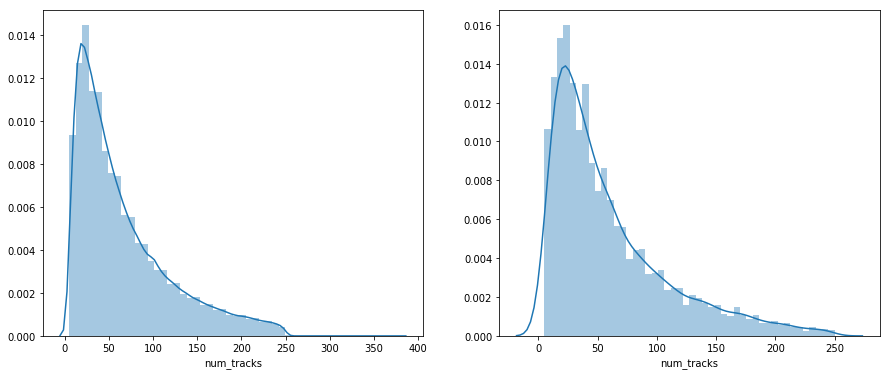

In [247]:
fig_nt, ax_nt = plt.subplots(1, 2, figsize=(15,6))
_ = sns.distplot(X_train['num_tracks'], ax=ax_nt[0])
_ = sns.distplot(X_dev['num_tracks'], ax=ax_nt[1])

In [248]:
show_describe_deltas(X_train['num_tracks'].describe(), X_dev['num_tracks'].describe())

,train,dev,delta,delta_ratio_percent
mean,66.474551,59.972800,6.501751,10.841166
std,53.743313,49.489977,4.253336,8.594339
min,5.000000,5.000000,0.000000,0.000000
25%,26.000000,23.000000,3.000000,13.043478
50%,49.000000,44.000000,5.000000,11.363636
75%,92.000000,81.000000,11.000000,13.580247
max,376.000000,250.000000,126.000000,50.400000


Even though the plots look slightly different, a closer look into descriptive features of both samples show the similarity of their distribution. The different plot appearance is driven by a way larger maximum value in the training set. This is a data point we'll keep in mind and might take into consideration when finetuning.

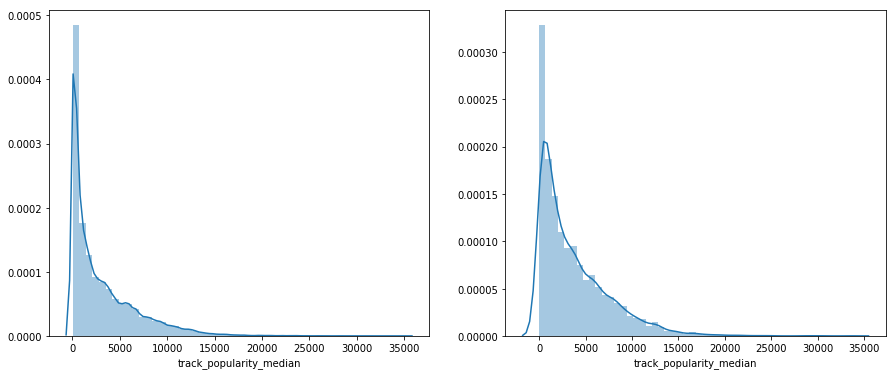

In [249]:
fig_pop, ax_pop = plt.subplots(1, 2, figsize=(15,6))
_ = sns.distplot(X_train['track_popularity_median'], ax=ax_pop[0])
_ = sns.distplot(X_dev['track_popularity_median'], ax=ax_pop[1])

In [250]:
show_describe_deltas(X_train['track_popularity_median'].describe(), X_dev['track_popularity_median'].describe())

,train,dev,delta,delta_ratio_percent
mean,3041.950303,3704.511100,-662.560797,-17.885243
std,3546.111790,3717.419533,-171.307743,-4.608243
min,1.000000,2.000000,-1.000000,-50.000000
25%,377.500000,799.750000,-422.250000,-52.797749
50%,1659.000000,2489.500000,-830.500000,-33.360112
75%,4558.000000,5576.750000,-1018.750000,-18.267808
max,35170.000000,33699.000000,1471.000000,4.365115


Both samples have similar characteristics for `track_popularity_median` as well. The largest difference is on its maximum value as well. Mean and standard deviation delta is very small as well.

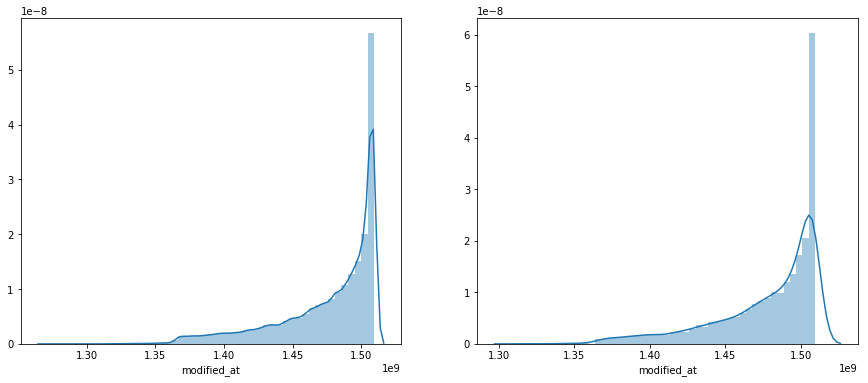

In [251]:
fig_ma, ax_ma = plt.subplots(1, 2, figsize=(15,6))
_ = sns.distplot(X_train['modified_at'], ax=ax_ma[0])
_ = sns.distplot(X_dev['modified_at'], ax=ax_ma[1])

In [252]:
show_describe_deltas(X_train['modified_at'].describe(), X_dev['modified_at'].describe())

,train,dev,delta,delta_ratio_percent
mean,1.476257e+09,1.477076e+09,-8.197792e+05,-0.055500
std,3.670084e+07,3.528126e+07,1.419581e+06,4.023613
min,1.271376e+09,1.313712e+09,-4.233600e+07,-3.222624
25%,1.458950e+09,1.460246e+09,-1.296000e+06,-0.088752
50%,1.490227e+09,1.489882e+09,3.456000e+05,0.023196
75%,1.505434e+09,1.505347e+09,8.640000e+04,0.005740
max,1.509494e+09,1.509494e+09,0.000000e+00,0.000000


Last but not least, both subsamples show similar characteristics for `modified_at`. The larges deviation takes place in the longtail region as well. Other delta ratios are diminishing small.

In [253]:
X_dev.shape

(10000, 23)

In [254]:
X_test.shape

(10000, 23)

In [255]:
X_train_pids = X_train.pid.values

In [256]:
X_dev_pids = X_dev.pid.values

In [257]:
X_test_pids = X_test.pid.values

## Storing Playlist IDs
To access the subsamples, we'll store their playlist ids.

In [69]:
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [70]:
def save_pickle_obj(obj, fname):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f)
        print ('File stored under {}'.format(fname))

In [70]:
if recompute:
    save_pickle_obj(X_train_pids, os.path.join(RESULTS_FOLDER, 'x_train_pids.pckl'))
    save_pickle_obj(X_dev_pids, os.path.join(RESULTS_FOLDER, 'x_dev_pids.pckl'))
    save_pickle_obj(X_test_pids, os.path.join(RESULTS_FOLDER, 'x_test_pids.pckl'))
else:
    X_train_pids = load_pickle_obj(os.path.join(RESULTS_FOLDER, 'x_train_pids.pckl'))
    X_dev_pids = load_pickle_obj(os.path.join(RESULTS_FOLDER, 'x_dev_pids.pckl'))
    X_test_pids = load_pickle_obj(os.path.join(RESULTS_FOLDER, 'x_test_pids.pckl'))

## Generate Sample Set
The same process is being used to generate a sample set containing 10 % of all data. To keep consistend with development and evaluation the dev and test set size doesn't change. This subsample is being used for more complicated and computational expensive models that might need a few iterations and evaluations until used on the whole data set.

In [71]:
if recompute:
    all_train_playlists = {}
    all_test_dev_playlists = {}
    for playlist in all_playlists:
        if playlist not in dev and playlist not in test:
            all_train_playlists[playlist] = all_playlists[playlist]
        else:
            all_test_dev_playlists[playlist] = all_playlists[playlist]

    test_dev_union = set()
    for p in all_test_dev_playlists:
        for track in all_test_dev_playlists[p]:
            test_dev_union.add(track)

To generate the 10 % subsample, a first subset of `X_train` is being searched that meets the criteria to contain any song within the dev and test sets. To do so, a reference list of all unique songs within dev and test sets is being created. By iterating over all playlists in the training set and adding playlists that contain at least one song of dev $\cup$ test, while crossing those track occurences off the reference list a minimum viable subset is generated.

In [72]:
if recompute:
    cross_off_list = set()
    candidate_list = []
    
    n_playlists = len(all_train_playlists)
    for ix, p in enumerate(all_train_playlists):
        if ix % 5000 == 0:
            clear_output(wait=True)
            print ('{:.2f} %'.format((((ix+1) / n_playlists) * 100)))
        is_candidate = False
        for track in all_train_playlists[p]:
            if track in test_dev_union and track not in cross_off_list:
                cross_off_list.add(track)
                is_candidate = True
        if is_candidate:
            candidate_list.append(p)
    
    delta_playlists = int(.1 * len(all_train_playlists) - len(candidate_list))
    print ('There are {:,} playlists missing to form a 10% training subsample.'.format(delta_playlists))

Afterwards, a random sample is being selected from the remaining candidates that are not yet in the list.

In [73]:
if recompute:
    remaining_candidates = set(all_train_playlists.keys()).difference(set(candidate_list))
    candidate_supplement = np.random.choice(list(remaining_candidates), size=50022, replace=False)
    candidate_list.extend(candidate_supplement)
    X_train_sample = candidate_list
    
    save_pickle_obj(X_train_sample, os.path.join(RESULTS_FOLDER, 'x_train_sample_pids.pckl'))
    
else:
    X_train_sample = load_pickle_obj(os.path.join(RESULTS_FOLDER, 'x_train_sample_pids.pckl'))

In [71]:
def get_current_time():
    return datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S.%f')

In [72]:
def extract_sample_set(data_folder, sample_pckl):
    sample_json = {'info': {'generated_on': get_current_time(), 'slice': 'sample_set', 'version': 'v1'},
                   'playlists': []
                  }
    file_names = os.listdir(data_folder)
    file_names = [x for x in file_names if '.json' in x]
    sample_dict_pids = load_pickle_obj(sample_pckl)
    counter = 0
    total_files = len(file_names)
    for file_name in file_names:
        counter += 1
        clear_output(wait=True) 
        print ("Working on slice {} ({:.2f} %) (File Name:  {} || Total Slices: {})".format(
                counter, (counter / total_files) * 100, file_name, total_files))
        with open(os.path.join(data_folder, file_name), 'r') as f:
            json_tmp = json.load(f)
            for playlist in json_tmp['playlists']:
                if playlist['pid'] in sample_dict_pids:
                    sample_json['playlists'].append(playlist)
    return sample_json

In [73]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [74]:
import re
import glob

def extract_sample_set_spliced(data_folder, sample_pckl, sample_data_folder):
    #gets the list of files sorted by theird index and filters only json files
    sorted_files = sorted(glob.glob(os.path.join(data_folder,'*.json')), key= lambda c: int(str(re.findall('[0-9]+', c)[0])))
    
    sample_dict_pids = load_pickle_obj(sample_pckl)
    sample_dicts_pids_spliced = chunks(sample_dict_pids, 1000)

    i = 0
    for pid_list in sample_dicts_pids_spliced:
        sample_json = {'info': {'generated_on': get_current_time(), 'slice': str(i), 'version': 'v1'},
                       'playlists': []
                      }
        print("info: creating json file with id %d" %i)
        print("info: lenght of list %d" %len(pid_list))
        for pid in pid_list:
            file_index = int(pid/1000)
            playlist_index = int(pid%1000)
            with open(os.path.join(data_folder, sorted_files[file_index]), 'r') as f:
                json_tmp = json.load(f)
                playlist = json_tmp['playlists'][playlist_index]
                print("info: number of tracks %s" %playlist['num_tracks'])
                sample_json['playlists'].append(playlist)
            f.close()
        sample_file_name = 'x_train_'+str(i)+'_samples.json'
        with open(os.path.join(sample_data_folder, sample_file_name), 'w') as f:
            json.dump(sample_json, f)
        f.close()
        i += 1000
        print("info: file created")

In [75]:
DATA_FOLDER = '../data/mpd/'
STORAGE_FOLDER = '../../workspace/'  # this is where the sample is saved

sample_file_name = 'x_train_98000_samples.json'

if recompute:
    data_folder = '../../workspace/data/'
    sample_pckl = os.path.join(RESULTS_FOLDER, 'x_train_sample_pids.pckl')
    sample = extract_sample_set(data_folder, sample_pckl)
    print (len(sample['playlists'])) # make sure the sample has the correct size
    
    with open(os.path.join(STORAGE_FOLDER, sample_file_name), 'w') as f:
        json.dump(sample, f)

else:
    with open(os.path.join(STORAGE_FOLDER, sample_file_name), 'r') as f:
        sample = json.load(f)

Working on slice 1000 (100.00 %) (File Name:  mpd.slice.718000-718999.json || Total Slices: 1000)
98000


The size of the sample set is around 1.8 GB.